QTM 350 Final Project Analysis Script

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf


df = pd.read_csv("../datasets/wdi_data.csv")

We began by removing non-country rows, such as metadata footers, to retain only valid observations. The dataset was then reshaped from wide to long format by unpivoting year columns, converting text-based year labels into numeric form, and filtering out missing or placeholder values. Finally, we pivoted indicators into separate columns, renamed them for clarity, converted all values to numeric, and dropped rows with no usable data to produce a clean, analysis-ready dataset.

1. Dataset cleaning

In [43]:
df = df[df["Country Name"].notna()]

year_cols = [col for col in df.columns if "YR" in col]
df_long = df.melt(
    id_vars=["Country Name", "Country Code", "Series Name", "Series Code"],
    value_vars=year_cols,
    var_name="Year", value_name="Value"
)

df_long["Year"] = df_long["Year"].str.extract(r"(\d{4})").astype(int)

df_long = df_long[df_long["Value"].notna()]
df_long = df_long[df_long["Value"] != ".."]

df_wide = df_long.pivot(
    index=["Country Name", "Country Code", "Year"],
    columns="Series Name",
    values="Value"
).reset_index()

df_wide = df_wide.rename(columns={
    "Life expectancy at birth, total (years)": "LifeExpectancy",
    "Fertility rate, total (births per woman)": "FertilityRate",
    "Population growth (annual %)": "PopGrowth",
    "School enrollment, primary (% gross)": "PrimaryEnrollGross"
})

for col in ["LifeExpectancy", "FertilityRate", "PopGrowth", "PrimaryEnrollGross"]:
    df_wide[col] = pd.to_numeric(df_wide[col], errors="coerce")

df_clean = df_wide.dropna(
    subset=["LifeExpectancy", "FertilityRate", "PopGrowth", "PrimaryEnrollGross"],
    how="all"
)

df_clean.head(10)


Series Name,Country Name,Country Code,Year,FertilityRate,LifeExpectancy,PopGrowth,PrimaryEnrollGross
0,Afghanistan,AFG,1970,7.400,37.460,2.445206,33.420010
1,Afghanistan,AFG,1971,7.432,37.932,2.428516,34.331341
2,Afghanistan,AFG,1972,7.453,38.423,2.442584,34.752682
3,Afghanistan,AFG,1973,7.487,38.951,2.534759,35.214371
4,Afghanistan,AFG,1974,7.526,39.469,2.526844,35.760830
5,Afghanistan,AFG,1975,7.542,39.994,2.415250,36.715912
6,Afghanistan,AFG,1976,7.561,40.518,2.213446,37.601509
7,Afghanistan,AFG,1977,7.591,41.082,2.128100,38.380409
8,Afghanistan,AFG,1978,7.599,40.086,2.008698,39.671021
9,Afghanistan,AFG,1979,7.612,38.844,0.323659,NaN


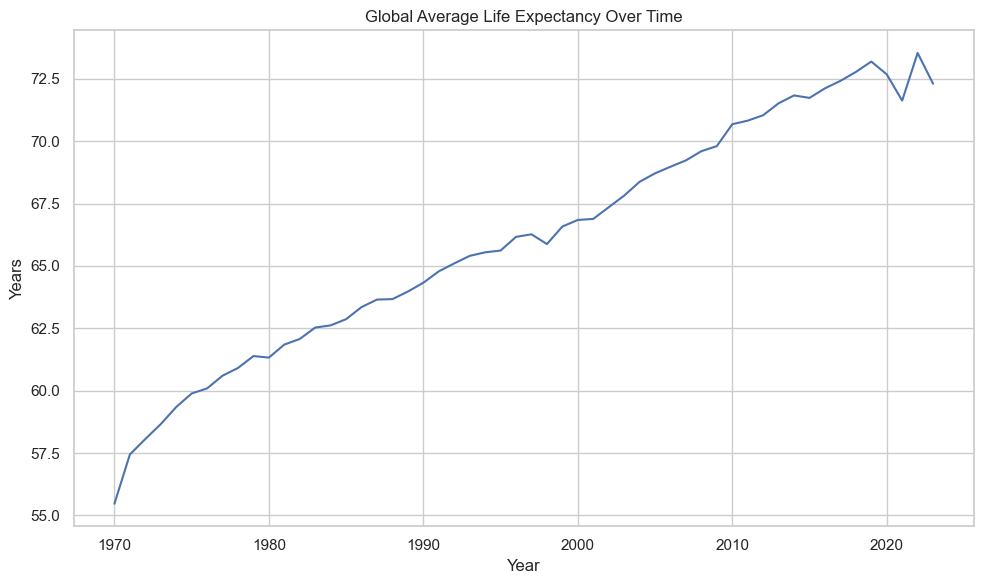

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# Make sure columns are numeric
for col in ['LifeExpectancy', 'FertilityRate', 'PopGrowth', 'PrimaryEnrollGross']:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# Drop rows with any missing indicator values
df = df_clean.dropna(subset=['LifeExpectancy', 'FertilityRate', 'PopGrowth', 'PrimaryEnrollGross'])

# --------------------------
# 1. Global Trend: Life Expectancy Over Time
# --------------------------
trend = df.groupby('Year')[['LifeExpectancy']].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(data=trend, x='Year', y='LifeExpectancy')
plt.title("Global Average Life Expectancy Over Time")
plt.ylabel("Years")
plt.xlabel("Year")
plt.tight_layout()
plt.show()

This plot shows the global average of life expectancy from 1960 to 2023. The steady increase reflects improvements in healthcare, nutrition, and living conditions worldwide.

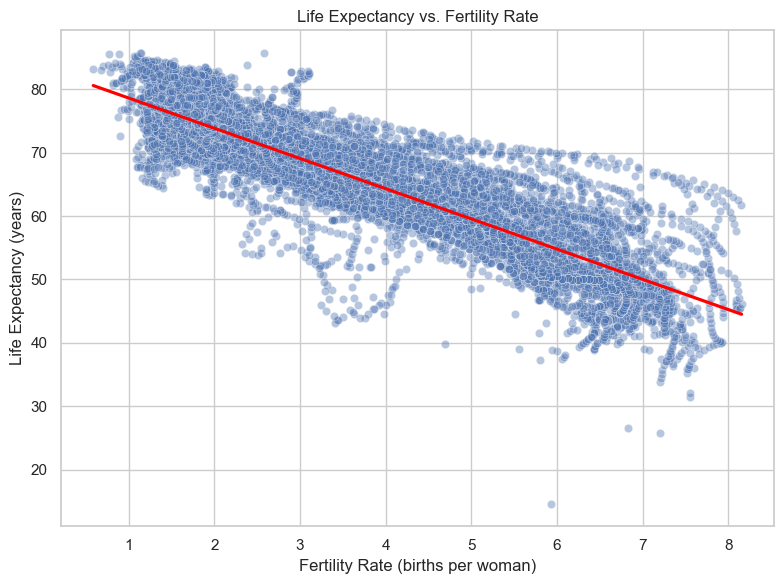

In [45]:
# --------------------------
# 2. Scatterplot: Life Expectancy vs Fertility Rate
# --------------------------
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='FertilityRate', y='LifeExpectancy', alpha=0.4)
sns.regplot(data=df, x='FertilityRate', y='LifeExpectancy', scatter=False, color='red')
plt.title("Life Expectancy vs. Fertility Rate")
plt.xlabel("Fertility Rate (births per woman)")
plt.ylabel("Life Expectancy (years)")
plt.tight_layout()
plt.show()

This scatterplot illustrates a strong inverse relationship: countries with higher fertility rates tend to have lower life expectancy. The fitted regression line highlights this negative correlation.

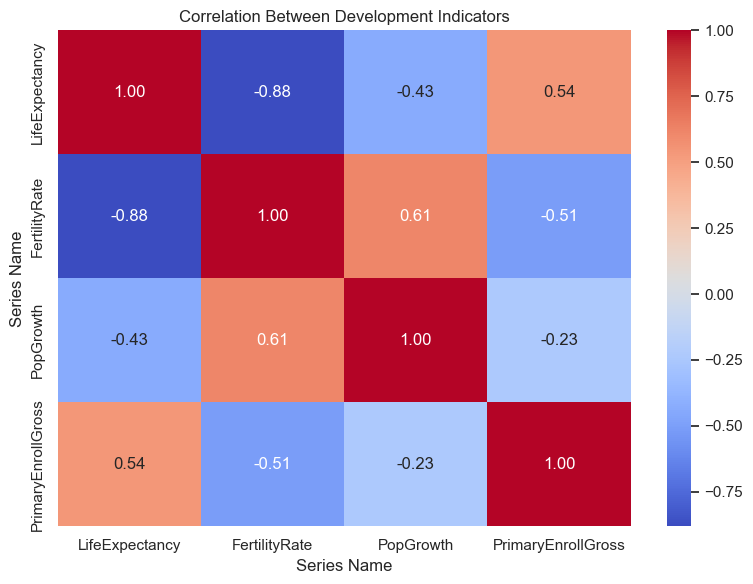

In [46]:
# --------------------------
# 3. Correlation Heatmap
# --------------------------
plt.figure(figsize=(8, 6))
sns.heatmap(df[['LifeExpectancy', 'FertilityRate', 'PopGrowth', 'PrimaryEnrollGross']].corr(),
            annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Development Indicators")
plt.tight_layout()
plt.show()


This heatmap visualizes pairwise Pearson correlation coefficients among life expectancy, fertility rate, population growth, and school enrollment. Life expectancy is positively associated with school enrollment and negatively with fertility and population growth.

In [47]:
# --------------------------
# 4. Regression: Life Expectancy ~ Fertility + PopGrowth + School Enroll
# --------------------------
model = smf.ols("LifeExpectancy ~ FertilityRate + PopGrowth + PrimaryEnrollGross", data=df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         LifeExpectancy   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                 1.481e+04
Date:                Wed, 23 Apr 2025   Prob (F-statistic):               0.00
Time:                        17:53:51   Log-Likelihood:                -32266.
No. Observations:               11020   AIC:                         6.454e+04
Df Residuals:                   11016   BIC:                         6.457e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             77.3726      0

This multivariate regression quantifies the combined effect of fertility rate, population growth, and school enrollment on life expectancy. All three predictors are statistically significant, reinforcing that education and controlled fertility support population health.

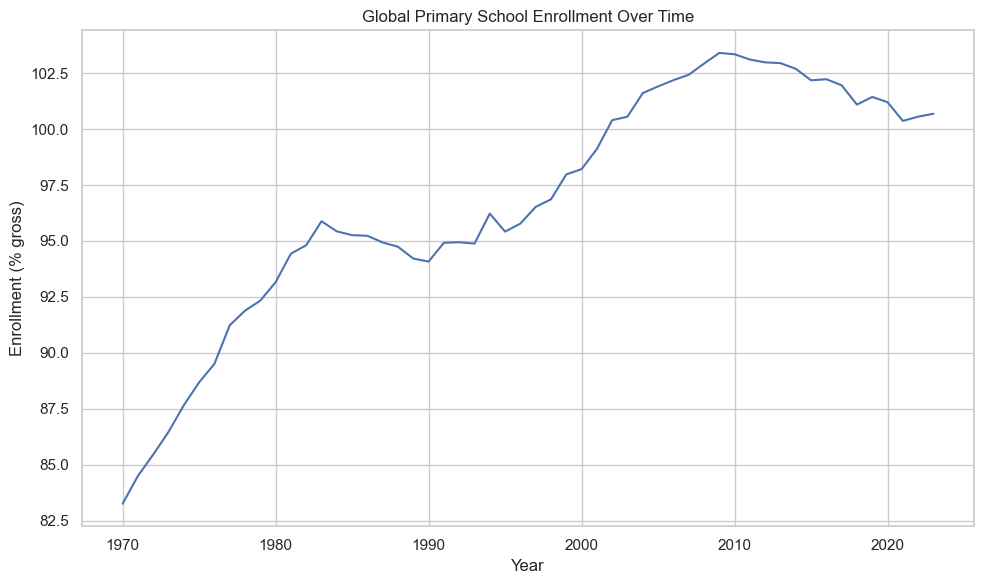

In [48]:
# --------------------------
# 5. School Enrollment Over Time
# --------------------------
enroll_trend = df.groupby('Year')[['PrimaryEnrollGross']].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(data=enroll_trend, x='Year', y='PrimaryEnrollGross')
plt.title("Global Primary School Enrollment Over Time")
plt.xlabel("Year")
plt.ylabel("Enrollment (% gross)")
plt.tight_layout()
plt.show()

This line plot tracks global average primary school enrollment (% gross) over time. The steady upward trend signals progress in education access globally, especially in developing countries.

# Comparison Among Countries

In [49]:
unique_countries = df["Country Name"].unique()

In [50]:
countries_to_check = ["China", "United States", "Mexico", "Japan", "Belarus", "United Kingdom"]
presence_check = {country: country in unique_countries for country in countries_to_check}
presence_check

{'China': True,
 'United States': True,
 'Mexico': True,
 'Japan': True,
 'Belarus': True,
 'United Kingdom': True}

### Country Selection Rationale

For our analysis, we selected a subset of countries that represent both developing and developed regions. This allows us to compare developmental trajectories and uncover key differences and similarities in long-term trends.

The selected countries are:

- **China** *(representing developing economies in Asia)*
- **Japan** *(representing developed economies in Asia)*
- **Belarus** *(representing developing economies in Europe)*
- **United Kingdom** *(representing developed economies)*
- **Mexico** *(representing developing economies in North America)*
- **United States** *(representing developed economies in North America)*



By comparing indicators such as life expectancy, fertility rate, population growth, and school enrollment across these countries, we aim to explore how development strategies and socioeconomic factors influence demographic and educational outcomes. This dual perspective (developing vs. developed) provides valuable context for interpreting global development trends.

## Process of dataset

In [51]:

developed = {"United States", "Japan", "United Kingdom"}

df["Development Status"] = df["Country Name"].apply(
    lambda x: "Developed" if x in developed else "Developing"
)

# Optional: preview a few rows with country info included
df_filtered = df[["Country Name", "Year", "Development Status", 
                  "FertilityRate", "LifeExpectancy", "PopGrowth", "PrimaryEnrollGross"]]



/var/folders/sp/sr_dyzzd7fz_lm3r5g6s4s0m0000gp/T/ipykernel_17634/3521729589.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Development Status"] = df["Country Name"].apply(


In [52]:
df_filtered.head()

Series Name,Country Name,Year,Development Status,FertilityRate,LifeExpectancy,PopGrowth,PrimaryEnrollGross
0,Afghanistan,1970,Developing,7.400,37.460,2.445206,33.420010
1,Afghanistan,1971,Developing,7.432,37.932,2.428516,34.331341
2,Afghanistan,1972,Developing,7.453,38.423,2.442584,34.752682
3,Afghanistan,1973,Developing,7.487,38.951,2.534759,35.214371
4,Afghanistan,1974,Developing,7.526,39.469,2.526844,35.760830


In [53]:
selected_countries = [
    "China", "Japan", "Belarus", "United Kingdom", "Mexico", "United States"
]

df_subset = df_filtered[df_filtered["Country Name"].isin(selected_countries)]

In [54]:
df_subset.head(5)

Series Name,Country Name,Year,Development Status,FertilityRate,LifeExpectancy,PopGrowth,PrimaryEnrollGross
1081,Belarus,1971,Developing,2.31,71.011707,0.832542,98.885452
1082,Belarus,1972,Developing,2.28,70.849317,0.801904,98.486702
1083,Belarus,1973,Developing,2.25,71.000659,0.740577,98.768021
1084,Belarus,1974,Developing,2.21,70.854683,0.649396,99.054001
1085,Belarus,1975,Developing,2.17,70.457098,0.528951,99.677994


## Comparison between Developing Country and Developed Country

In [56]:
df_subset = df_subset.rename(columns={
    'Development Status': 'Development_Status',
    'Country Name': 'Country_Name'
})

# Drop NA values
df_model = df_subset.dropna(subset=[
    'LifeExpectancy', 'FertilityRate', 'PrimaryEnrollGross',
    'Development_Status', 'Country_Name', 'Year'
])

# Run the model with country and year fixed effects
fe_model = smf.ols(
    formula='LifeExpectancy ~ FertilityRate * C(Development_Status) + PrimaryEnrollGross + C(Country_Name) + C(Year)',
    data=df_model
).fit()

# Print the results
print(fe_model.summary())


                            OLS Regression Results                            
Dep. Variable:         LifeExpectancy   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     38.49
Date:                Wed, 23 Apr 2025   Prob (F-statistic):           4.83e-87
Time:                        17:54:43   Log-Likelihood:                -514.74
No. Observations:                 275   AIC:                             1153.
Df Residuals:                     213   BIC:                             1378.
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

We estimated a linear regression model to evaluate how **fertility rate**, **primary school enrollment**, and **development status** relate to **life expectancy**, while controlling for **country-specific and year-specific effects** using fixed effects via dummy variables.

#### Model Specification:
$$
\begin{aligned}
\text{LifeExpectancy}_{it} =\ & 
\beta_0 + \beta_1 \cdot \text{FertilityRate}_{it} + \beta_2 \cdot \text{DevelopmentStatus}_i \\
& + \beta_3 \cdot (\text{FertilityRate} \times \text{DevelopmentStatus}) \\
& + \beta_4 \cdot \text{PrimaryEnrollGross}_{it} \\
& + \text{Country FE}_i + \text{Year FE}_t + \epsilon_{it}
\end{aligned}
$$

#### Key Findings:
- **R-squared = 0.917** and **Adjusted R-squared = 0.893**: The model explains a very high proportion of the variance in life expectancy.
- **Fertility Rate** is strongly and negatively associated with life expectancy in developed countries. This effect is moderated (weaker) in developing countries.
- **Primary School Enrollment (Gross)** is included as a control but was not statistically significant in this specification.
- **Country fixed effects** capture large differences in baseline life expectancy:
  - Japan (+22.13), United Kingdom (+20.71), United States (+19.33), Mexico (+3.74), and China (+1.69) show significantly higher life expectancy compared to the baseline country Belarus.
- **Year fixed effects** are mostly small and statistically insignificant, suggesting minimal change across years once other factors are accounted for.
  

#### Summary:
This fixed effects model confirms that **fertility rate remains a strong predictor of life expectancy**, particularly in developed countries. Country-level differences dominate the life expectancy gap, as captured by the country fixed effects. The interaction between fertility and development status reveals that the negative relationship between fertility and life expectancy is **much steeper in developed countries** than in developing ones.



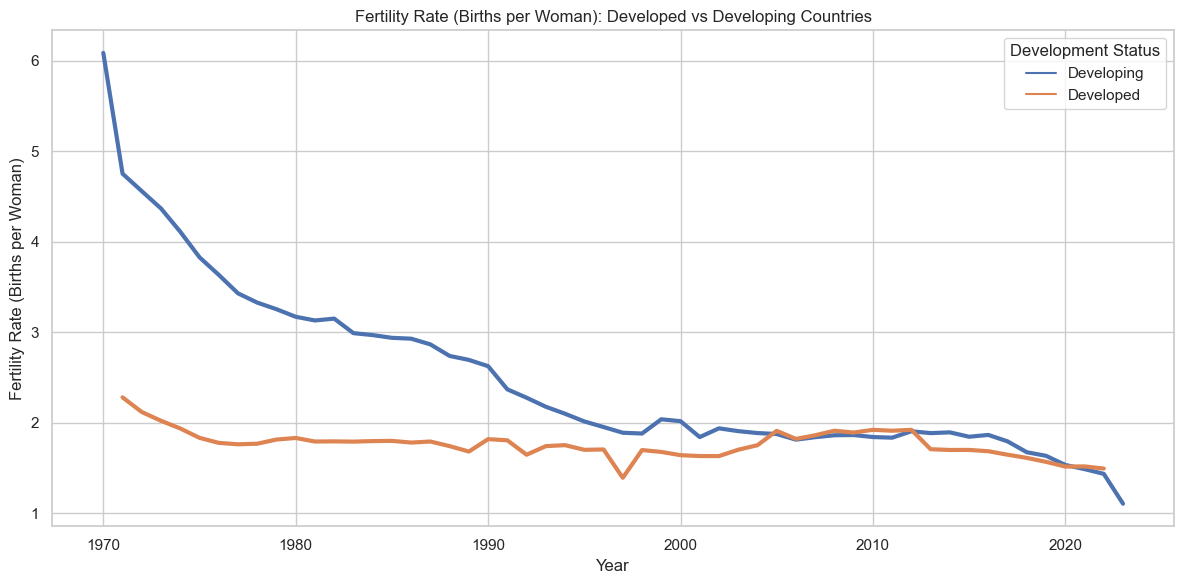

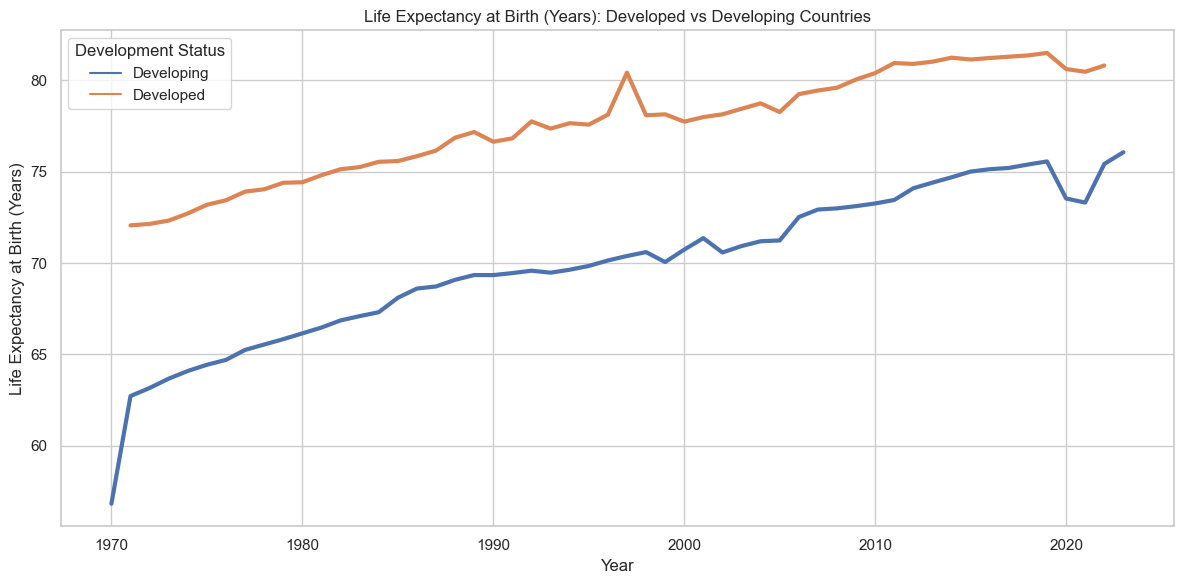

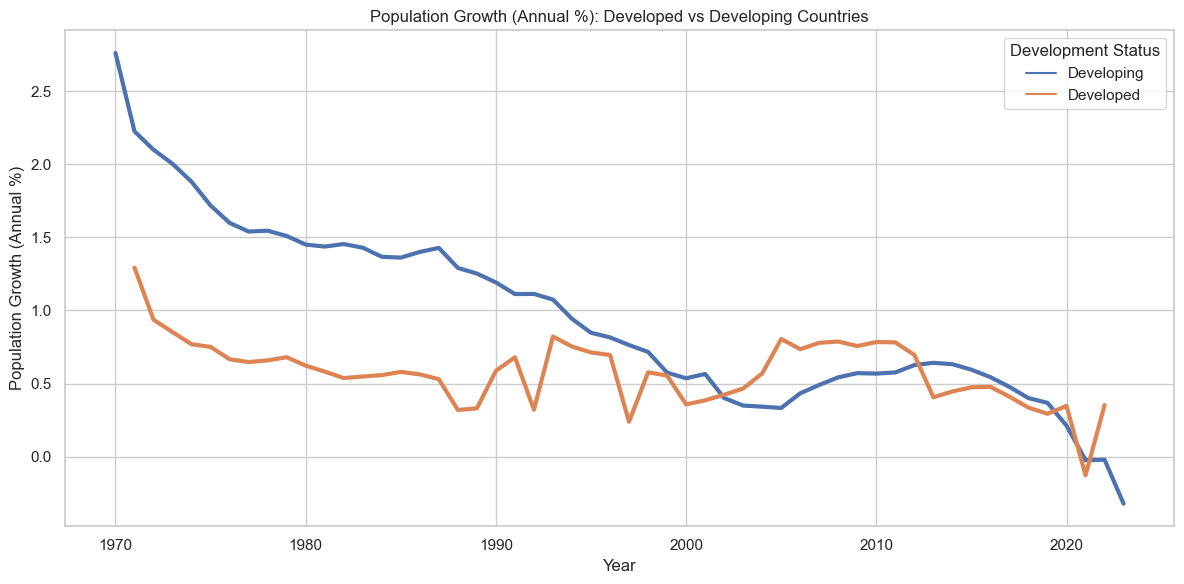

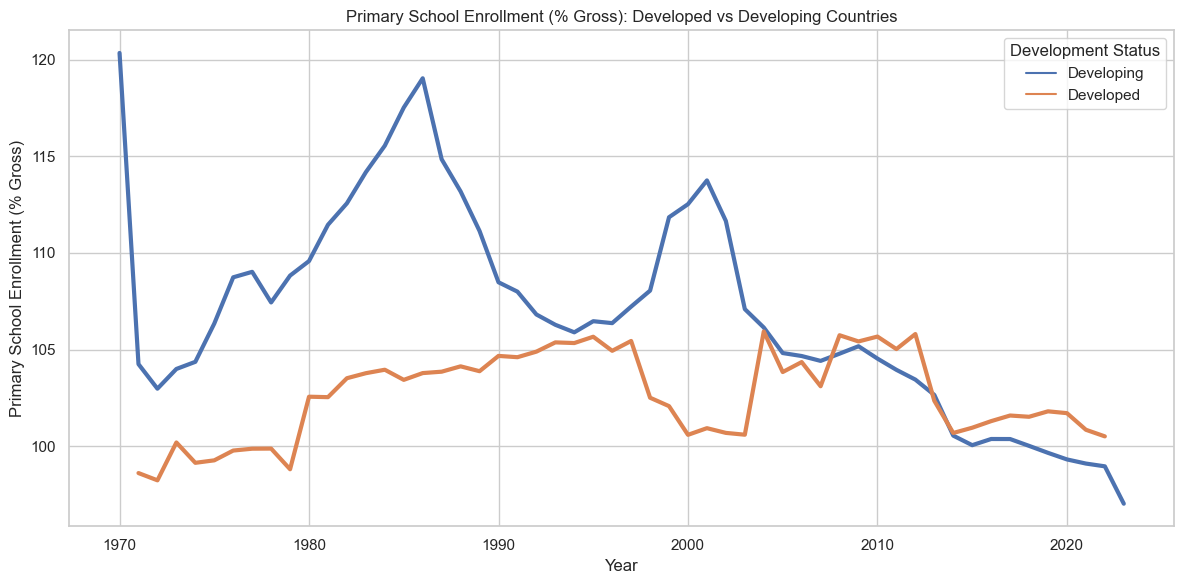

In [58]:
df_mean = df_subset.groupby(["Year", "Development_Status"])[
    ["FertilityRate", "LifeExpectancy", "PopGrowth", "PrimaryEnrollGross"]
].mean().reset_index()

# Plot style
sns.set(style="whitegrid")

# Indicator titles
indicators = ["FertilityRate", "LifeExpectancy", "PopGrowth", "PrimaryEnrollGross"]
titles = {
    "FertilityRate": "Fertility Rate (Births per Woman)",
    "LifeExpectancy": "Life Expectancy at Birth (Years)",
    "PopGrowth": "Population Growth (Annual %)",
    "PrimaryEnrollGross": "Primary School Enrollment (% Gross)"
}

for indicator in indicators:
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_mean, x="Year", y=indicator, hue="Development_Status", linewidth=3)
    plt.title(f"{titles[indicator]}: Developed vs Developing Countries")
    plt.xlabel("Year")
    plt.ylabel(titles[indicator])
    plt.legend(title="Development Status")
    plt.tight_layout()
    plt.show()

# Compute the Rate of Change

In [17]:

def avg_yearly_change_flexible(df, var):
    df_var = df[["Year", var, "Country Name"]].dropna()
    
    grouped = df_var.groupby("Country Name")
    first = grouped.apply(lambda x: x.sort_values("Year").iloc[0])
    last = grouped.apply(lambda x: x.sort_values("Year").iloc[-1])

    rate = (last[var].values - first[var].values) / (last["Year"].values - first["Year"].values)
    return pd.Series(rate, index=grouped.groups.keys(), name=f"{var}_AvgChangePerYear")

change_fertility = avg_yearly_change_flexible(df_subset, "FertilityRate")
change_lifeexp = avg_yearly_change_flexible(df_subset, "LifeExpectancy")
change_popgrowth = avg_yearly_change_flexible(df_subset, "PopGrowth")
change_enroll = avg_yearly_change_flexible(df_subset, "PrimaryEnrollGross")

df_avg_change_flexible = pd.concat([change_fertility, change_lifeexp, change_popgrowth, change_enroll], axis=1).reset_index()
df_avg_change_flexible = df_avg_change_flexible.rename(columns={"index": "Country Name"})

In [18]:

df_avg_change_flexible_rounded = df_avg_change_flexible.copy()
numeric_cols = df_avg_change_flexible_rounded.select_dtypes(include='number').columns
df_avg_change_flexible_rounded[numeric_cols] = df_avg_change_flexible_rounded[numeric_cols].round(3)

In [19]:
display(df_avg_change_flexible_rounded)

,Country Name,FertilityRate_AvgChangePerYear,LifeExpectancy_AvgChangePerYear,PopGrowth_AvgChangePerYear,PrimaryEnrollGross_AvgChangePerYear
0,Belarus,-0.021,0.061,-0.026,-0.080
1,China,-0.096,0.399,-0.054,-0.397
2,Japan,-0.018,0.219,-0.052,0.047
3,Mexico,-0.088,0.285,-0.046,0.002
4,United Kingdom,-0.017,0.171,0.014,-0.030
5,United States,-0.012,0.124,-0.018,0.095


#### Summary:

Over the observed period, all six countries experienced a **decline in fertility rates**, with **China** showing the steepest average yearly decrease at **-0.096 births per woman per year**, followed by **Mexico** at **-0.088**. In contrast, **the United States** and **United Kingdom** saw the smallest fertility declines. **Life expectancy increased** across all countries, with **China** again leading in improvement (**+0.399 years per year**), while **Belarus** showed the smallest gain (**+0.061**). **Population growth rates** declined in every country except the **United Kingdom**, which had a slight increase. Trends in **primary school enrollment** were mixed: **Belarus** and **China** experienced notable declines, while **Japan** and the **United States** saw modest increases. These patterns reflect how demographic and development dynamics have evolved differently across developed and developing nations.

# Difference Among Continents

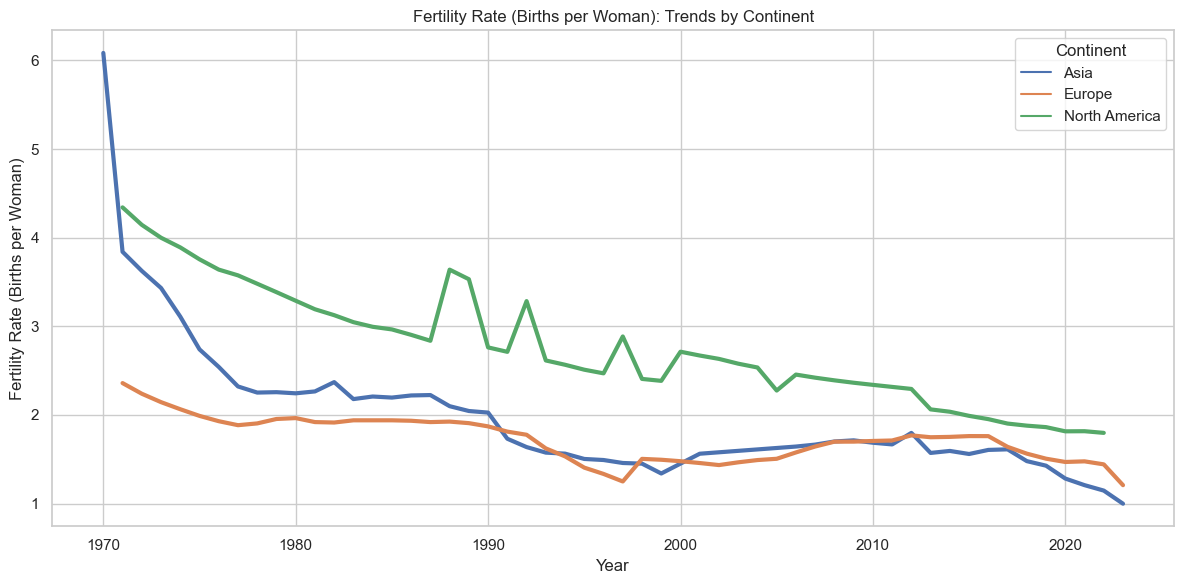

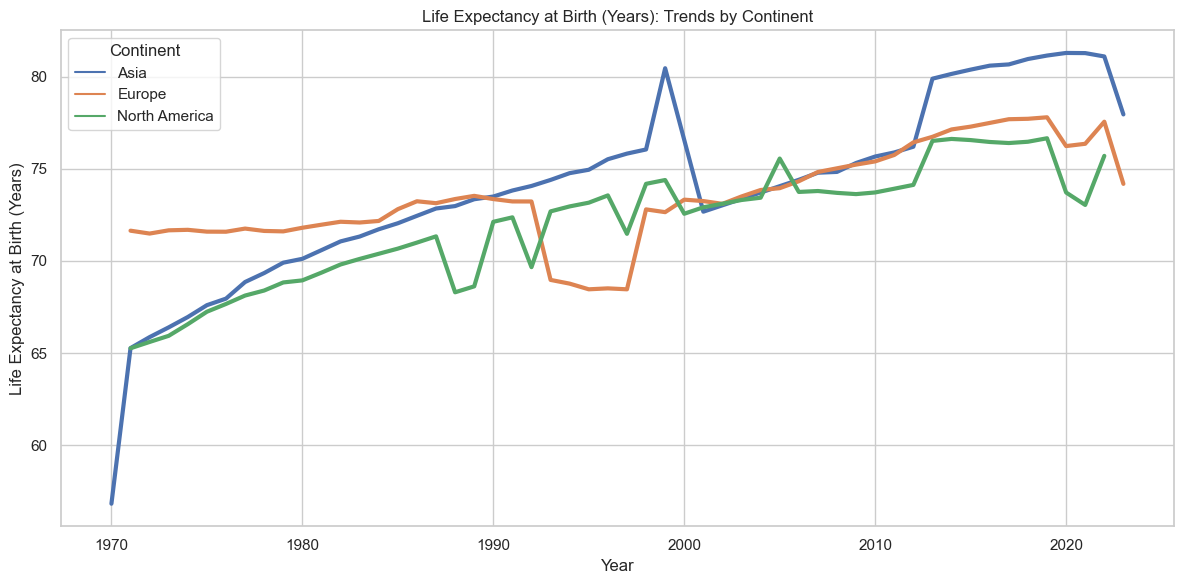

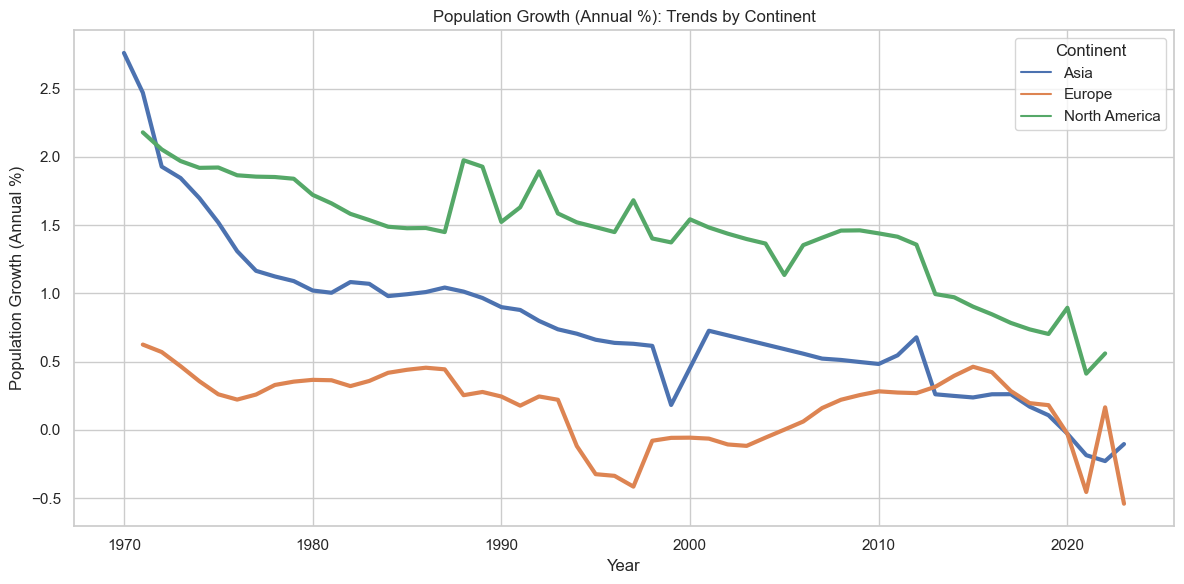

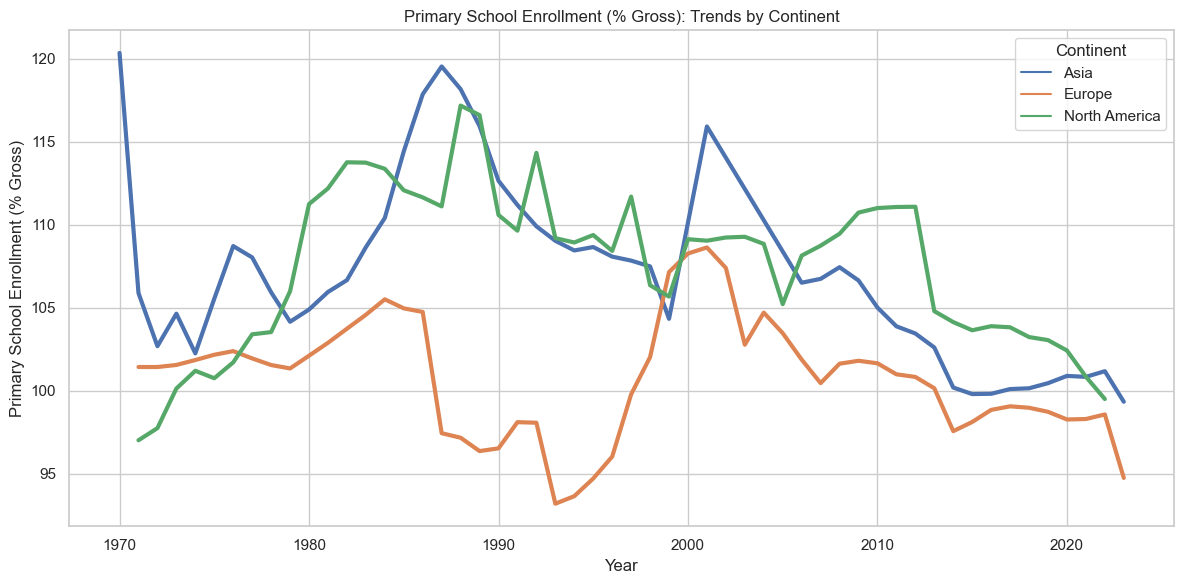

In [62]:
continent_map = {
    "China": "Asia",
    "Japan": "Asia",
    "United States": "North America",
    "Mexico": "North America",
    "United Kingdom": "Europe",
    "Belarus": "Europe"
}
df_subset["Continent"] = df_subset["Country_Name"].map(continent_map)

# Group and average indicators by Year + Continent
df_continent_mean = df_subset.groupby(["Year", "Continent"])[
    ["FertilityRate", "LifeExpectancy", "PopGrowth", "PrimaryEnrollGross"]
].mean().reset_index()

# Plot setup
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
titles = {
    "FertilityRate": "Fertility Rate (Births per Woman)",
    "LifeExpectancy": "Life Expectancy at Birth (Years)",
    "PopGrowth": "Population Growth (Annual %)",
    "PrimaryEnrollGross": "Primary School Enrollment (% Gross)"
}

# Plot all indicators by continent
for indicator in titles:
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_continent_mean, x="Year", y=indicator, hue="Continent", linewidth=3)
    plt.title(f"{titles[indicator]}: Trends by Continent")
    plt.xlabel("Year")
    plt.ylabel(titles[indicator])
    plt.legend(title="Continent")
    plt.tight_layout()
    plt.show()